# Saving Data in directory as you go

One option for storing a lot of data is to just collect everything and then process it later. This is especially helpful when: 
- The data is complex and you don't know what parts you're going to need or how to process it.
- You're collecting a large amount of data and you don't want to have to hold it all in memory.

In [1]:
from requests import get
import time
import pandas as pd 
import numpy as np
import os
import json

## API Example

We'll start by pulling data from the world bank and storing each page of results. 

The `os.makedirs` function will make a new folder in the current working directory unless a folder with that name already exists (in which case it does nothing)

In [2]:

os.makedirs('./worldbank_data/', exist_ok=True)

Next, I'll pull every page of data for every country's greenhouse gas emissions

In [3]:
page = 1

while True:
    url = 'https://api.worldbank.org/v2/country/indicator/EN.GHG.CO2.PC.CE.AR5'
    params = {'format':'json',
              'per_page':1000,
              'page' : page
         }
    result= get(url, params=params)
    filename = './worldbank_data/worldbank_page_' + str(page) + '.json'
    with open(filename, "w") as outfile:
        outfile.write(result.text)
    if result.json()[0].get('page') >= result.json()[0].get('pages'):
        print('last page reached')
        break
    time.sleep(.3)
    page = page + 1
    





last page reached


Now, that I have my data stored, I can load it into a data frame using `os.listdir` (which lists all the files in a directory) along with a conditional statement (`if 'worldbank_page' in i`) that gives me a list of all the `.json` files I downloaded. Then I'll write a function that parses each saved page and converts it to a data frame, then I'll use `pd.concat` to combine the list of data frames in to one long data set:

In [4]:
all_pages = ['./worldbank_data/' + i for i in os.listdir('./worldbank_data')  if 'worldbank_page' in i ]

In [5]:
def wdi_reader(jsonfile, mode='r'):
    with open(jsonfile) as file:
        result_json = json.load(file)
    result_dict = [{'country_id':i['countryiso3code'],
                    'country_name':i['country']['value'],
                    'date': int(i['date']),
                    'indicator': i['indicator']['id'],
                    'indicator_description' : i['indicator']['value'],
                    'indicator_value': np.float64(i['value'])} for i in result_json[1]]
    return pd.DataFrame(result_dict)

In [6]:
wdi_data = [wdi_reader(i) for i in all_pages]

In [7]:
wdi_df = pd.concat(wdi_data)


How have greenhouse gas emissions changed over time across income groups?

<Axes: title={'center': 'Greenhouse gas emissions by income group'}, xlabel='date'>

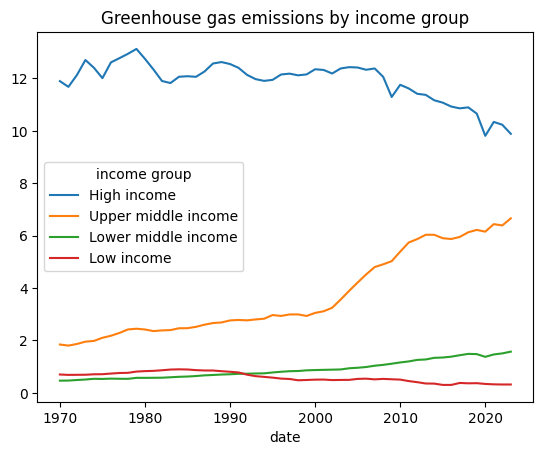

In [8]:
income_groups = ["High income", "Upper middle income", "Lower middle income", "Low income"]
emissions_by_group = wdi_df[wdi_df['country_name'].isin(income_groups)].pivot(index ='date', columns='country_name', values='indicator_value').rename_axis(['income group'], axis=1)
emissions_by_group[income_groups].plot(title = "Greenhouse gas emissions by income group", label='')



## Webscraping Example

This is also an option for webscraping. The primary difference here is that you'll want to read in the data and store the results as `.html`.

This code is pulling data from https://www.twoinchbrush.com/all-paintings, a fan website about the painter instructor Bob Ross. We'll use the resulting data for a project later in the semester

In [9]:
from bs4 import BeautifulSoup
from urllib.parse import urljoin


Visting each page of data. Check out https://www.twoinchbrush.com/all-paintings to get a sense of what we're actually pulling from here

In [10]:
links = []
for i in range(1, 18):
    print(i, end='\r')
    params = {'page':i}
    paintings = get('https://www.twoinchbrush.com/all-paintings', params=params)
    soup = BeautifulSoup(paintings.content, 'html.parser')
    links.extend([urljoin(paintings.url, i.get('href')) for i in soup.select('.bob-ross-painting-holder a')])
    time.sleep(.4)
    

Now we'll make a new directory for the paintings and then visit each URL and collect data on each individual painting. We'll save each result separately in a file inside the `bobross_paintings` directory (this will take a minute or so, its about 400 urls)

In [11]:
os.makedirs('./bobross_paintings/', exist_ok=True)
for i in links:
    print(i, end='\r')
    newfile_name = i.replace('https://www.twoinchbrush.com/painting/', './bobross_paintings/') + ".html"
    page = get(i)
    page.raise_for_status()  # will raise an error if no response
    with open(newfile_name, "w", encoding="utf-8") as file:
        file.write(page.text)
    time.sleep(.1)

### Reading the data back in 

And now I'll just write a function that formats each page as a dictionary and then use that to make a data frame. Here again, instead of using `get` to read in the data, I'm going to read the HTML from a file I've saved locally, so this function takes a file name and spits out a dictionary with data on that page:

In [28]:
def parse_painting(file_name):
    with open(file_name, encoding="utf-8", mode='r') as file:
        soup = BeautifulSoup(file, 'html.parser')
    colors = soup.select('#color-list span ')
    painting_info = {
        'title':soup.select(".flex-grow-1")[0].get_text(),
        'episode':soup.select('.mb-3 span')[0].get_text(),
        'hexcolors':[i.get('data-hex') for i in colors],
        'color_names':[i.get('data-name') for i in colors],
        'tags':[i.get_text() for i in soup.select_one('.mb-2').select(' .color-list .badge')],
        'image_url':urljoin('https://www.twoinchbrush.com/painting/', soup.select('.col-md-6.mb-3 img')[0].get('src'))
    }
    return painting_info

Now I'll get a list of saved .html files in the `bobross_paintings` folder, and then apply my parsing function to each one, and put the results in a data frame.

In [29]:
# list all the files in the directory with a .html extension
all_pages = ['./bobross_paintings/' + i for i in os.listdir('./bobross_paintings/')  if '.html' in i ]

# read all the pages and parse the results
data = [parse_painting(i) for i in all_pages]

# make a data frame from the dictionary
paintings_df = pd.DataFrame(data)
paintings_df.head()

,title,episode,hexcolors,color_names,tags,image_url
0,A Cold Spring Day,'The Joy of Painting' S30E11,"[#4E1500, #DB0000, #FFEC00, #5F2E1F, #FFB800, ...","[Alizarin Crimson, Bright Red, Cadmium Yellow,...","[Mountains, Forest, Spring, Autumn, Clear Sky,...",https://www.twoinchbrush.com/images/painting39...
1,A Copper Winter,'The Joy of Painting' S30E5,"[#4E1500, #DB0000, #FFEC00, #5F2E1F, #FFB800, ...","[Alizarin Crimson, Bright Red, Cadmium Yellow,...","[Forest, Autumn, Winter, Clear Sky, Sunset/Sun...",https://www.twoinchbrush.com/images/painting39...
2,A Mild Winter's Day,'The Joy of Painting' S17E6,"[#4E1500, #DB0000, #FFEC00, #5F2E1F, #FFB800, ...","[Alizarin Crimson, Bright Red, Cadmium Yellow,...","[Foothills, Forest, Winter, Clear Sky, Sunset/...",https://www.twoinchbrush.com/images/painting76...
3,A Perfect Winter Day,'The Joy of Painting' S29E11,"[#4E1500, #5F2E1F, #000000, #0C0040, #021E44, ...","[Alizarin Crimson, Dark Sienna, Midnight Black...","[Mountains, Foothills, Forest, Winter, Clear S...",https://www.twoinchbrush.com/images/painting38...
4,A Pretty Autumn Day,'The Joy of Painting' S24E5,"[#4E1500, #000000, #DB0000, #FFEC00, #FFB800, ...","[Alizarin Crimson, Black Gesso, Bright Red, Ca...","[Mountains, Foothills, Forest, Rocks, Spring, ...",https://www.twoinchbrush.com/images/painting31...
